SimRank Scores (Partial):


,0,4,12,18,25,30,46,55,58,59,...,34,404,31,158,395,227,240,356,434,456
0,1.000000,0.022752,0.021619,0.022940,0.022034,0.017925,0.020992,0.020598,0.016835,0.024535,...,0.010624,0.008309,0.0,0.006182,0.009135,0.0,0.0,0.0,0.0,0.0
4,0.022752,1.000000,0.018124,0.027585,0.024085,0.019527,0.019741,0.022202,0.019606,0.023637,...,0.009794,0.008566,0.0,0.006154,0.008728,0.0,0.0,0.0,0.0,0.0
12,0.021619,0.018124,1.000000,0.023134,0.018363,0.018759,0.018562,0.016986,0.016254,0.019562,...,0.010124,0.008706,0.0,0.007155,0.008935,0.0,0.0,0.0,0.0,0.0
18,0.022940,0.027585,0.023134,1.000000,0.023399,0.020691,0.020863,0.019786,0.018919,0.022959,...,0.012084,0.007969,0.0,0.006210,0.008532,0.0,0.0,0.0,0.0,0.0
25,0.022034,0.024085,0.018363,0.023399,1.000000,0.020788,0.020363,0.018978,0.016629,0.021845,...,0.009638,0.008394,0.0,0.006169,0.009381,0.0,0.0,0.0,0.0,0.0


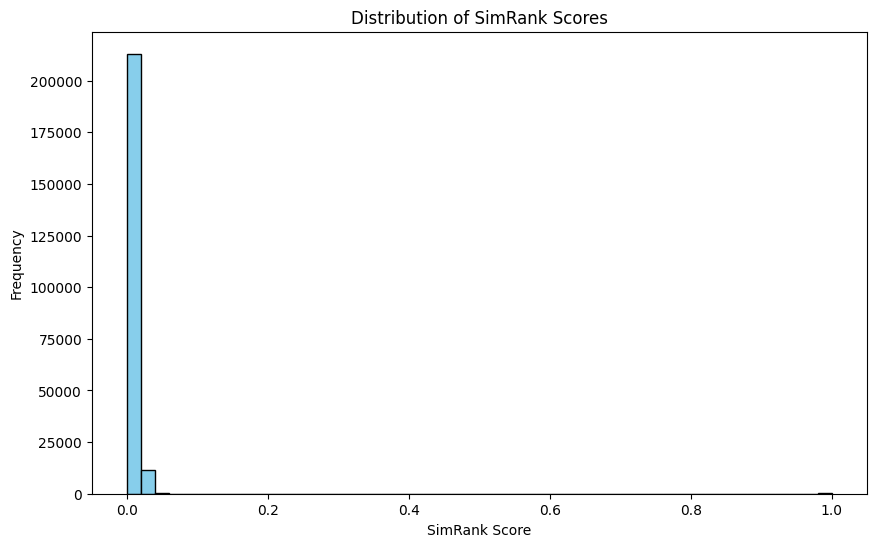

Top 5 Most Similar Node Pairs:


,Node1,Node2,SimRank Score
0,67,34,0.213189
1,19,34,0.142825
2,258,337,0.127791
3,458,34,0.121901
4,402,258,0.111217


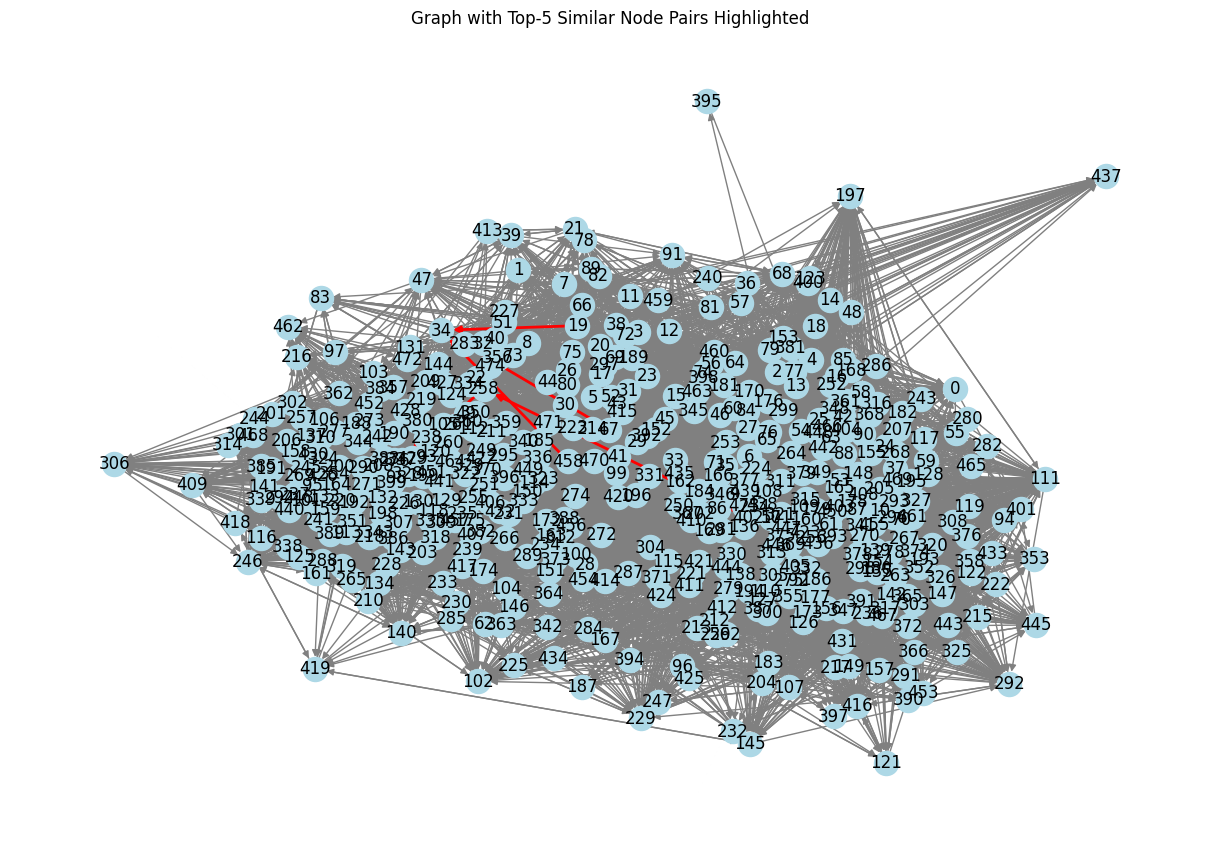

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Step 1: Load the Directed Graph from edgelist file
file_path = "congress.edgelist"  # Update with your file's path
graph = nx.read_edgelist(file_path, create_using=nx.DiGraph(), nodetype=str)

# Step 2: Compute SimRank Scores
def simrank(G, c=0.8, max_iter=100, eps=1e-4):
    """Calculate SimRank scores for all nodes in a graph."""
    nodes = list(G.nodes())
    n = len(nodes)
    sim = np.identity(n)  # Initialize similarity scores
    node_idx = {node: idx for idx, node in enumerate(nodes)}

    for _ in range(max_iter):
        prev_sim = sim.copy()
        for i, u in enumerate(nodes):
            for j, v in enumerate(nodes):
                if u == v:
                    continue

                predecessors_u = list(G.predecessors(u))
                predecessors_v = list(G.predecessors(v))

                if not predecessors_u or not predecessors_v:
                    sim[i, j] = 0
                else:
                    sim[i, j] = (c / (len(predecessors_u) * len(predecessors_v))) * sum(
                        prev_sim[node_idx[pre_u], node_idx[pre_v]]
                        for pre_u in predecessors_u
                        for pre_v in predecessors_v
                    )

        # Check convergence
        if np.linalg.norm(sim - prev_sim) < eps:
            break

    return sim, nodes

sim_matrix, node_list = simrank(graph)
sim_df = pd.DataFrame(sim_matrix, index=node_list, columns=node_list)

# Step 3: Display SimRank Scores
print("SimRank Scores (Partial):")
display(sim_df.head())

# Save to a CSV file for further inspection
sim_df.to_csv("simrank_scores.csv")

# Step 4: Visualize SimRank Scores
plt.figure(figsize=(10, 6))
plt.hist(sim_matrix.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of SimRank Scores")
plt.xlabel("SimRank Score")
plt.ylabel("Frequency")
plt.show()

# Step 5: Insights from SimRank Scores
# Find the top-5 most similar node pairs
sim_scores = []
for i, u in enumerate(node_list):
    for j, v in enumerate(node_list):
        if i < j:  # Avoid duplicate pairs
            sim_scores.append((u, v, sim_matrix[i, j]))

sorted_scores = sorted(sim_scores, key=lambda x: -x[2])

print("Top 5 Most Similar Node Pairs:")
display(pd.DataFrame(sorted_scores[:5], columns=["Node1", "Node2", "SimRank Score"]))

# Step 6: Graph Analysis based on SimRank
# Highlight the most similar node pairs on the graph
most_similar_pairs = [(u, v) for u, v, score in sorted_scores[:5]]

pos = nx.spring_layout(graph)
plt.figure(figsize=(12, 8))
nx.draw(graph, pos, with_labels=True, node_color='lightblue', edge_color='gray')
nx.draw_networkx_edges(graph, pos, edgelist=most_similar_pairs, edge_color='red', width=2)
plt.title("Graph with Top-5 Similar Node Pairs Highlighted")
plt.show()

# Save the graph with highlighted pairs
nx.write_gexf(graph, "highlighted_graph.gexf")


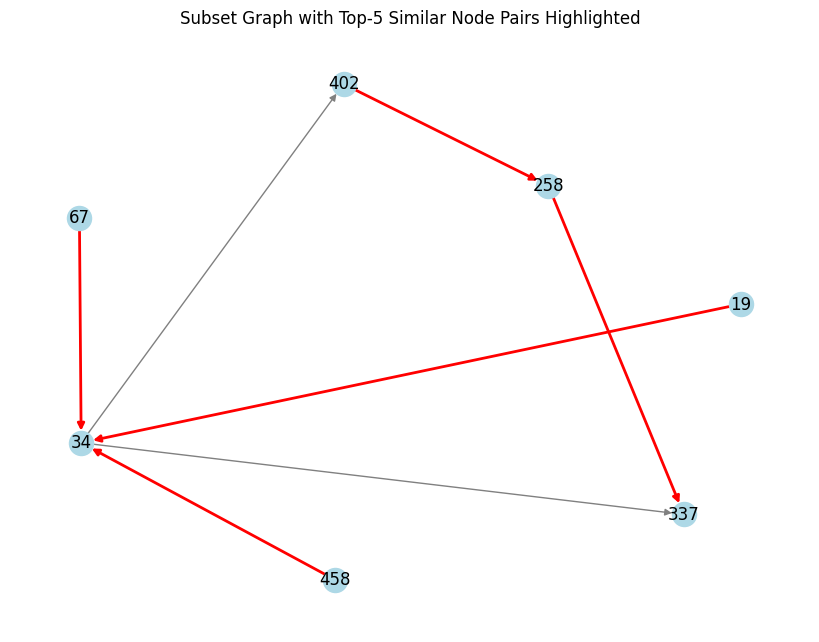

In [2]:
# Step 1: Select a subset of nodes and edges for detailed visualization
subset_nodes = set()
for u, v, _ in sorted_scores[:5]:  # Include nodes from the top-5 similar pairs
    subset_nodes.add(u)
    subset_nodes.add(v)

subset_graph = graph.subgraph(subset_nodes)

# Step 2: Visualize the subset graph
subset_pos = nx.spring_layout(subset_graph)
plt.figure(figsize=(8, 6))
nx.draw(subset_graph, subset_pos, with_labels=True, node_color='lightblue', edge_color='gray')
nx.draw_networkx_edges(subset_graph, subset_pos, edgelist=most_similar_pairs, edge_color='red', width=2)
plt.title("Subset Graph with Top-5 Similar Node Pairs Highlighted")
plt.show()
